In [ ]:
import pathlib
import pandas as pd

folder = pathlib.Path('./Kickstarter_2025-10-13T07_42_31_884Z')
csv_files = folder.glob('Kickstarter*.csv')

dfs = []
for p in csv_files:
    try:
        df = pd.read_csv(p)
        df['source_file'] = p.name
        dfs.append(df)
    except Exception as e:
        print("Failed")

    merged = pd.concat(dfs, ignore_index=True)
    out_path = folder / 'Kickstarter_merged.csv'
    merged.to_csv(out_path, index=False)
    print(f"Wrote merged CSV to {out_path} with {merged.shape[0]} rows and {merged.shape[1]} columns")



Found 83 CSV files to merge
Wrote merged CSV to Kickstarter_2025-10-13T07_42_31_884Z/Kickstarter_merged.csv with 262412 rows and 43 columns


In [ ]:
from ast import literal_eval
import numpy as np
#######################
#######################
# DATA PREPROCESSING
#######################
#######################
data_df = pd.read_csv('./Kickstarter_2025-10-13T07_42_31_884Z/Kickstarter_merged.csv')

data_df.drop(columns=['creator', 'country_displayable_name', 'currency_symbol', 'currency_trailing_code', 'current_currency', 
                            'disable_communication', 'photo', 'profile', 'source_url', 'urls'])
data_df = data_df[(data_df.state == "successful") | (data_df.state == "failed")]

data_df.drop_duplicates(subset=['id', 'state'], inplace=True)
# Converting datetime objects
data_df['created_at'] = data_df['created_at'].astype(int)
data_df['created_at'] = pd.to_datetime(data_df['created_at'],unit='s')
data_df['deadline'] = data_df['deadline'].astype(int)
data_df['deadline'] = pd.to_datetime(data_df['deadline'], unit='s')
data_df['launched_at'] = data_df['launched_at'].astype(int)
data_df['launched_at'] = pd.to_datetime(data_df['launched_at'],unit='s')
data_df['state_changed_at'] = data_df['state_changed_at'].astype(int)
data_df['state_changed_at'] = pd.to_datetime(data_df['state_changed_at'],unit='s')
category = data_df.category.apply(literal_eval)
main_category = []
for i, data in enumerate(category):
    try:
        main_category.append(data['parent_name'])
    except:
        main_category.append(np.nan)
data_df['main_category'] = main_category
print(data_df.main_category.value_counts())
sub_category = []
for i, name in enumerate(d['name'] for d in category):
    sub_category.append(name)
data_df['sub_category'] = sub_category
data_df.main_category.fillna(data_df.sub_category, inplace=True)
print(data_df.sub_category.value_counts())
data_df['goal'] = data_df.goal.astype(float)
data_df['fx_rate'] = data_df.fx_rate.astype(float)
data_df['goal_usd'] = data_df.goal * data_df.fx_rate

data_df.info()

ks = data_df[['id', 'goal_usd', 'country', 'created_at', 'deadline',  'launched_at', 'state_changed_at',
                  'spotlight','staff_pick', 'main_category', 'sub_category', 'blurb', 'state']]

ks.to_csv("./dataset/process_ks.csv", index= False)


main_category
Film & Video    26282
Music           25501
Publishing      20324
Art             16212
Technology      16176
Food            14851
Games           13440
Fashion         10320
Design           7818
Crafts           6840
Comics           6400
Photography      6392
Theater          5715
Journalism       3847
Dance            1986
Name: count, dtype: int64
sub_category
Tabletop Games    6352
Web               3411
Comedy            2755
Anthologies       2700
Product Design    2520
                  ... 
Publishing          30
Fashion             30
Games               26
Film & Video        23
Taxidermy           14
Name: count, Length: 161, dtype: int64


/var/folders/43/5fgbl97x0ps7q234n55l5jg40000gn/T/ipykernel_23265/1092480248.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df.main_category.fillna(data_df.sub_category, inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 186372 entries, 0 to 262410
Data columns (total 46 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   backers_count                       186372 non-null  int64         
 1   blurb                               186369 non-null  object        
 2   category                            186372 non-null  object        
 3   converted_pledged_amount            186372 non-null  float64       
 4   country                             186372 non-null  object        
 5   country_displayable_name            186372 non-null  object        
 6   created_at                          186372 non-null  datetime64[ns]
 7   creator                             186372 non-null  object        
 8   currency                            186372 non-null  object        
 9   currency_symbol                     186372 non-null  object        
 10  currency_trai

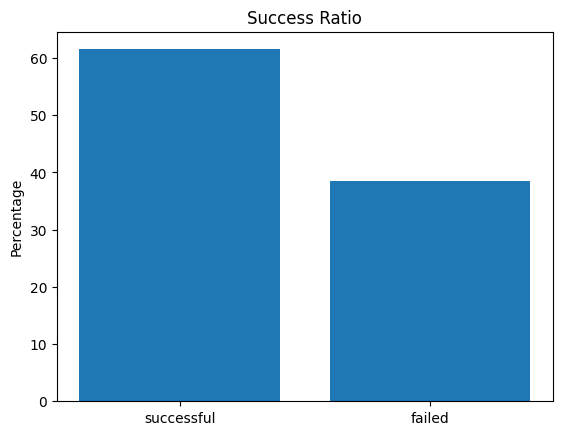

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

process_df= pd.read_csv('./dist/process_ks.csv')
target = process_df.state.value_counts(normalize=True) 
plt.figure()
plt.bar(target.index, target.values)
plt.title('Success Ratio')
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _pos: f'{x * 100:.0f}'))

Text(0.5, 0.98, '')

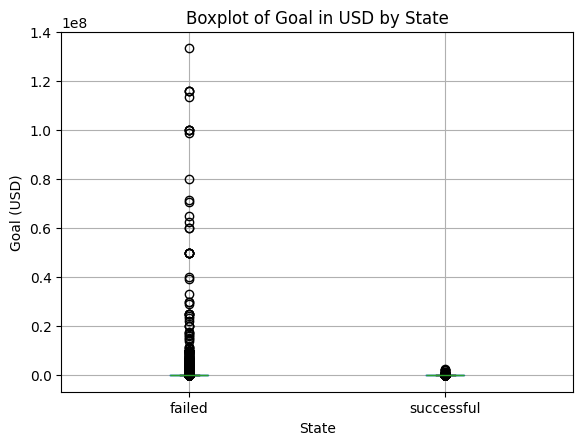

In [ ]:
process_df.boxplot(column='goal_usd', by='state', vert=True)
plt.title('Boxplot of Goal in USD by State')
plt.xlabel('State')
plt.ylabel('Goal (USD)')


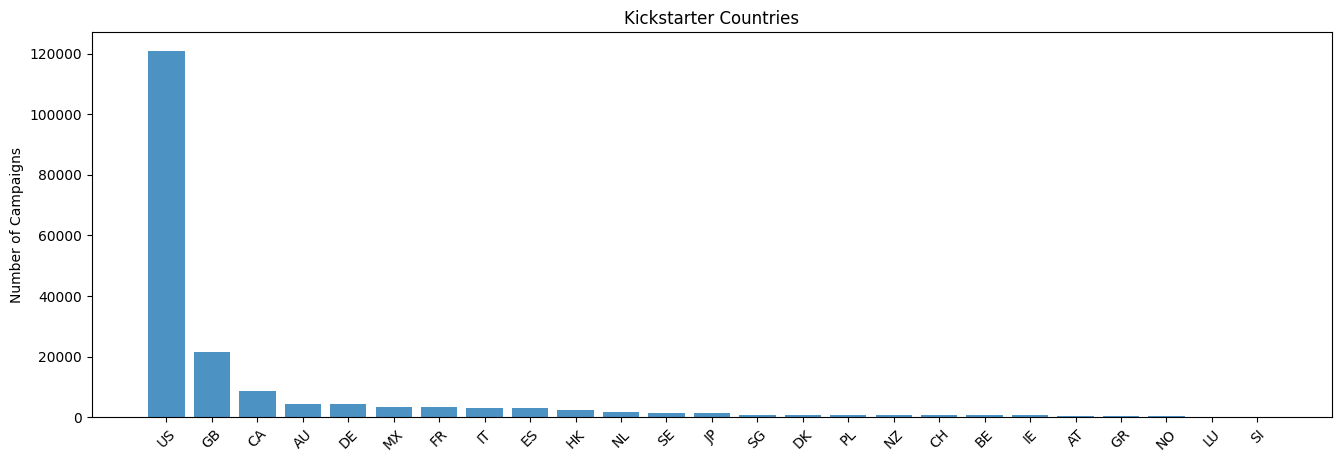

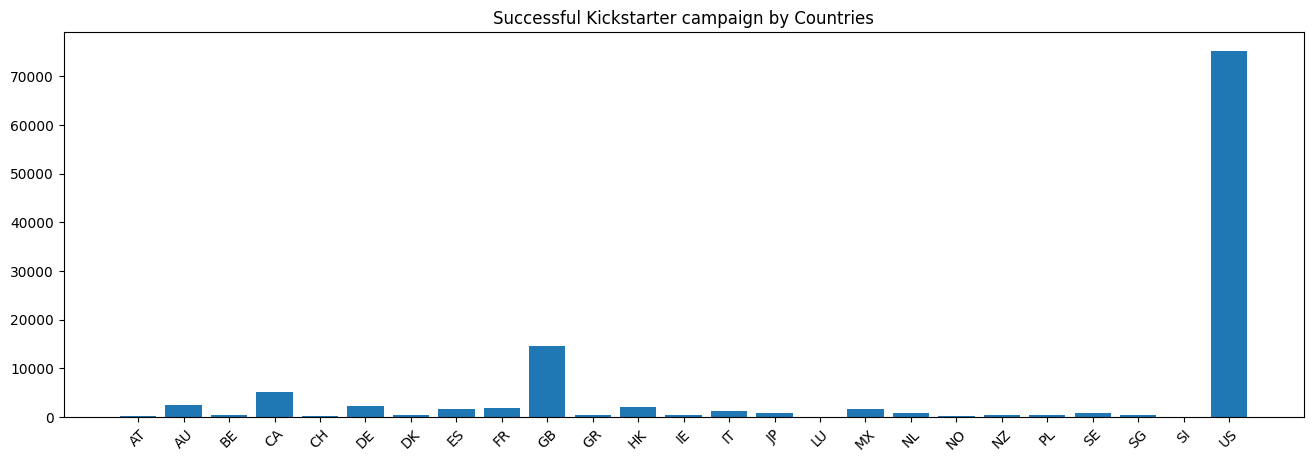

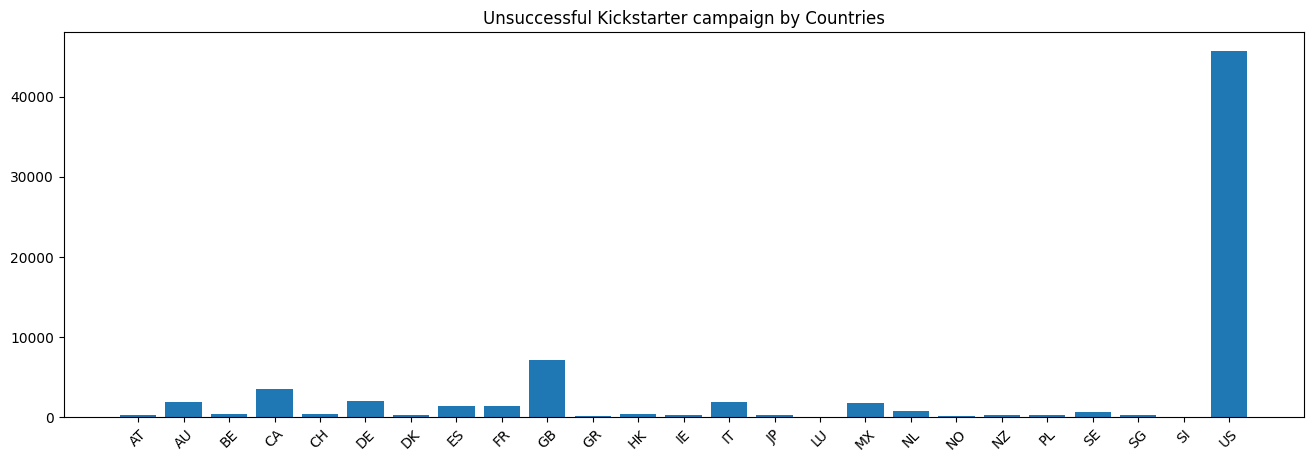

In [37]:
country_list = process_df.country.value_counts()
plt.figure(figsize=(16,5))
plt.bar(country_list.index, country_list.values, alpha=0.8)
plt.title('Kickstarter Countries')
plt.ylabel('Number of Campaigns');
plt.xticks(rotation=45);


country_success = process_df[process_df['state'] == 'successful'].groupby(['country']).size()
plt.figure(figsize=(16,5))
plt.bar(country_success.index, country_success.values)
plt.title('Successful Kickstarter campaign by Countries')
plt.xticks(rotation=45);

country_success = process_df[process_df['state'] != 'successful'].groupby(['country']).size()
plt.figure(figsize=(16,5))
plt.bar(country_success.index, country_success.values)
plt.title('Unsuccessful Kickstarter campaign by Countries')
plt.xticks(rotation=45);


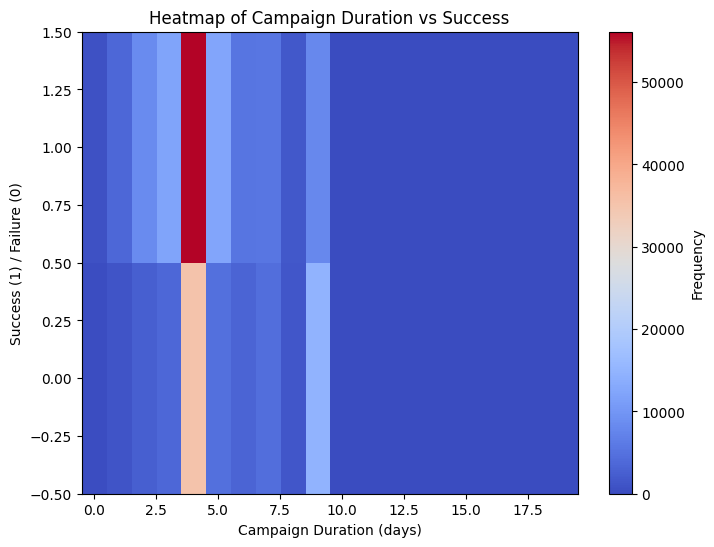

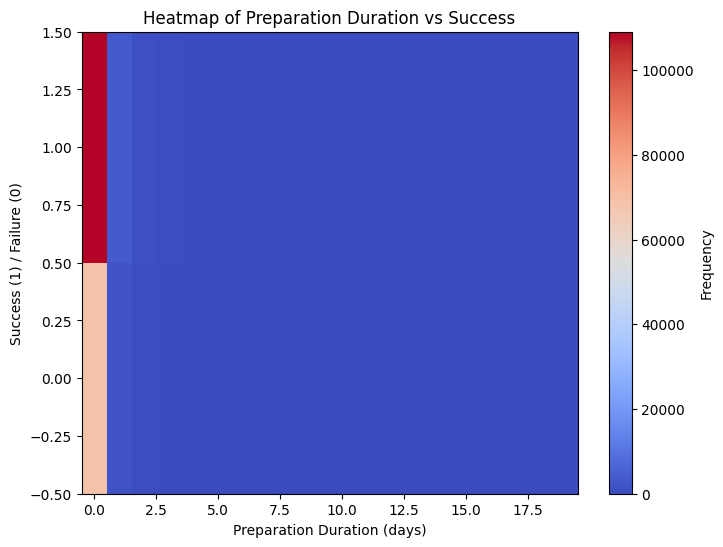

In [ ]:
process_df['created_at'] = pd.to_datetime(process_df.created_at)
process_df['launched_at'] = pd.to_datetime(process_df.launched_at)
process_df['deadline'] = pd.to_datetime(process_df.deadline)

prep_date = process_df.created_at.values
start_date = process_df.launched_at.values
end_date = process_df.deadline.values

# campaign duration = from launched time to deadline
process_df['cam_duration'] = pd.to_timedelta(end_date - start_date).days
process_df['prep_duration'] = pd.to_timedelta(start_date - prep_date).days

success_mapping = process_df['state'].map({'successful': 1, 'failed': 0})
heatmap_data = np.histogram2d(process_df['cam_duration'], success_mapping, bins=(20, 2))

plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data[0].T, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Frequency')
plt.xlabel('Campaign Duration (days)')
plt.ylabel('Success (1) / Failure (0)')
plt.title('Heatmap of Campaign Duration vs Success')
plt.show()

heatmap_data = np.histogram2d(process_df['prep_duration'], success_mapping, bins=(20, 2))

plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data[0].T, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Frequency')
plt.xlabel('Preparation Duration (days)')
plt.ylabel('Success (1) / Failure (0)')
plt.title('Heatmap of Preparation Duration vs Success')
plt.show()

main_category
Art             11723
Comics           5294
Crafts           3086
Dance            2390
Design           4882
Fashion          5585
Film & Video    17329
Food             5813
Games            9490
Journalism       1545
Music           18322
Photography      3431
Publishing      13226
Technology       8649
Theater          3889
dtype: int64


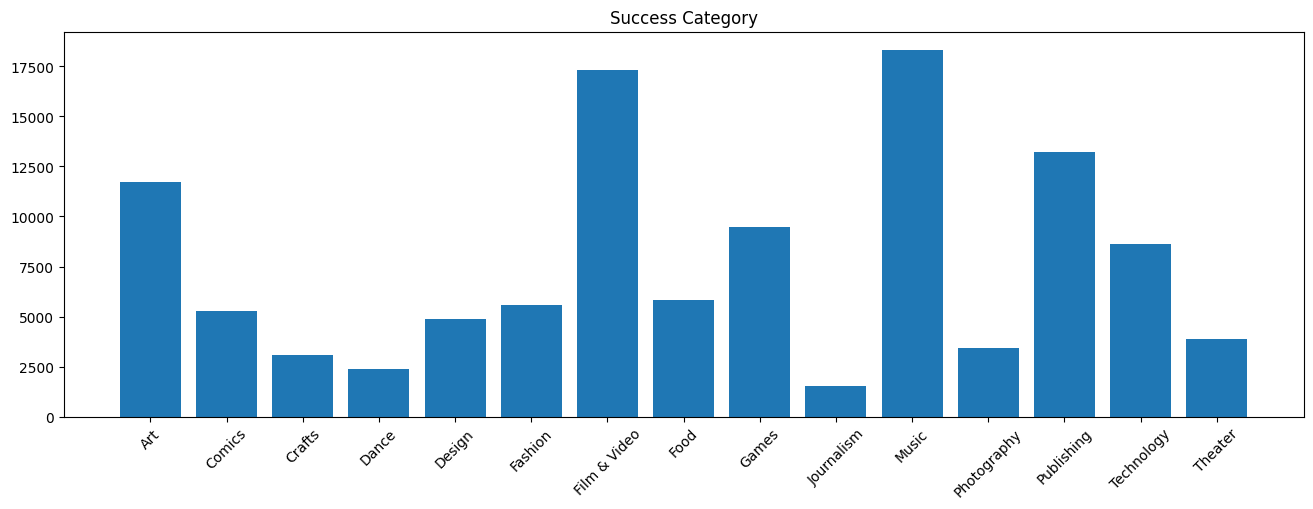

In [43]:
category_success = process_df[process_df['state'] == 'successful'].groupby(['main_category']).size()
print(category_success)
plt.figure(figsize=(16,5))
plt.bar(category_success.index, category_success.values)
plt.title('Success Category')
plt.xticks(rotation=45);